## Import Dependencies

In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import imutils
import numpy as np
import cv2
import tensorflow as tf

## Read Image, Grayscale and Blur

In [ ]:
image = cv2.imread('C:/Users/UCA/Documents/number-plates/images/Cars1.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))

## Apply filter and find edges for localization

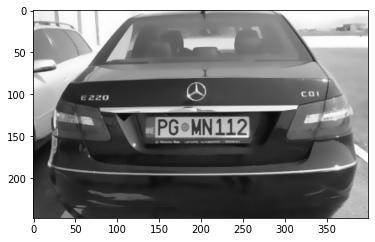

In [3]:
bfilter = cv2.bilateralFilter(gray, 11, 17, 17) #Noise reduction
plt.imshow(cv2.cvtColor(bfilter, cv2.COLOR_BGR2RGB))

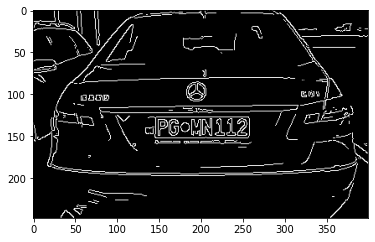

In [4]:
edged = cv2.Canny(bfilter, 170, 200) #Edge detection
plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))

## Find Contours and Apply Mask

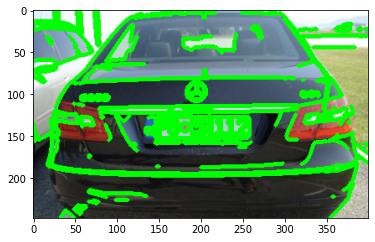

In [5]:
cnts, new = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
img1 = image.copy() 
cv2.drawContours(img1, cnts ,-1, (0,255,0), 3)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))

In [6]:
cnts = sorted(cnts, key=cv2.contourArea, reverse = True)[:30]
NumberPlateCnt = None # we do not have a number plate contour

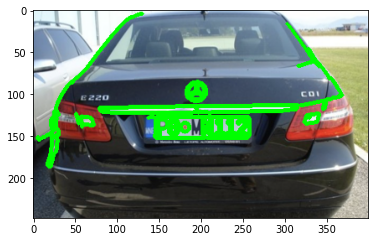

In [7]:
img2 = image.copy()
cv2.drawContours(img2,cnts,-1, (0,255,0), 3)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))

In [8]:
count=0
idx=7
for c in cnts:
    peri=cv2.arcLength(c,True)
    approx=cv2.approxPolyDP(c,0.03*peri,True)   #output number of edge in contour
    if len(approx) == 4:                        #contour with 4 corners
        location = approx                 #our approx numnuber plate contour
        
        #crop contours and store it into cropped images folder
        x,y,w,h = cv2.boundingRect(c)                                    #find co-ordinate for plate
        new_img = image[y:y+h, x:x+w]                                    #create new image
        cv2.imwrite('Cropped Images-Text/' + str(idx) + '.png', new_img) #save new image
        idx+=1
        break

In [9]:
location  #location of the license plate in the image

array([[[137, 128]],

       [[146, 152]],

       [[258, 149]],

       [[257, 127]]], dtype=int32)

In [10]:
mask = np.zeros(gray.shape, np.uint8)
new_image = cv2.drawContours(mask, [location], 0,255, -1)
new_image = cv2.bitwise_and(image, image, mask=mask)

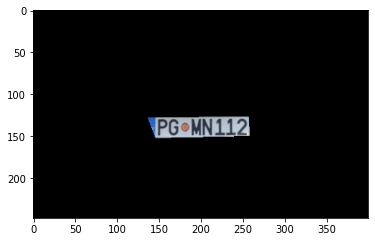

In [11]:
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))

In [11]:
mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [12]:
(x,y) = np.where(mask==255)
(x1, y1) = (np.min(x), np.min(y))
(x2, y2) = (np.max(x), np.max(y))
cropped_image = gray[x1:x2+1, y1:y2+1]

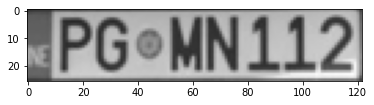

In [13]:
plt.imshow(cv2.cvtColor(cropped_image,cv2.COLOR_RGB2BGR))

In [14]:
cv2.imwrite('plate.jpg',cropped_image)

True

## Find contours for characters inside the plate

In [1]:

def contouring(dimensions, img) :


    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    bottom_width = dimensions[0]
    top_width = dimensions[1]
    bottom_height = dimensions[2]
    top_height = dimensions[3]
    
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    read_2 = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        
        if intWidth > bottom_width and intWidth < top_width and intHeight > bottom_height and intHeight < top_height :
            x_cntr_list.append(intX) 
            char_copy = np.zeros((44,24))
            
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(read_2, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(read_2, cmap='gray')

            char = cv2.subtract(255, char)

            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) 
            
    plt.show()

    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])
    img_res = np.array(img_res_copy)


    return img_res

## Character segmentation

In [16]:
def segmentation(image) :

    segment_image = cv2.resize(image, (333, 75))
    segment_image_gray = cv2.cvtColor(segment_image, cv2.COLOR_BGR2GRAY)
    _, segment_image_binary = cv2.threshold(segment_image_gray, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    segment_image_binary = cv2.erode(segment_image_binary, (3,3))
    segment_image_binary = cv2.dilate(segment_image_binary, (3,3))

    LP_WIDTH = segment_image_binary.shape[0]
    LP_HEIGHT = segment_image_binary.shape[1]

    segment_image_binary[0:3,:] = 255
    segment_image_binary[:,0:3] = 255
    segment_image_binary[72:75,:] = 255
    segment_image_binary[:,330:333] = 255

    
    dimensions = [LP_WIDTH/5,
                       LP_WIDTH/1,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(segment_image_binary, cmap='gray')
    plt.show()
    cv2.imwrite('contour.jpg',segment_image_binary)

    char_list = contouring(dimensions, segment_image_binary)

    return char_list

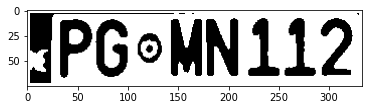

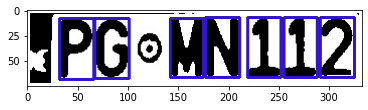

In [17]:
img = cv2.imread('plate.jpg')
char = segmentation(img)

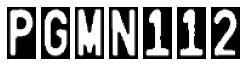

In [18]:
for i in range(7):
    plt.subplot(1, 10, i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')

## Building the model

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2,
    zoom_range=0.2,
    validation_split=0.25)
train_generator = train_datagen.flow_from_directory('dataset_characters', 
        target_size=(28,28), 
        batch_size=32,
        class_mode='categorical',
        subset='training')

validation_generator = train_datagen.flow_from_directory(
        'dataset_characters',  
        target_size=(28,28),  
        class_mode='categorical',
        subset='validation',
        shuffle=False)

Found 28227 images belonging to 36 classes.
Found 9396 images belonging to 36 classes.


In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D
from tensorflow.keras import optimizers

In [28]:
model = Sequential([
        
        layers.Conv2D(filters=32, kernel_size=3, activation='relu',
                      padding='same', input_shape=(28,28,3)),
        layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
        layers.MaxPool2D(pool_size=(2, 2)),
        layers.Dropout(0.25),
    
        layers.BatchNormalization(),
        layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding = 'same'),
        layers.Conv2D(filters=64, kernel_size=3, activation='relu'),
        layers.MaxPool2D(pool_size=(2, 2)),
        layers.Dropout(0.25),

        layers.BatchNormalization(),
        layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding = 'same'),
        layers.Conv2D(filters=128, kernel_size=3, activation='relu'),
        layers.MaxPool2D(pool_size=(2, 2)),
        layers.Dropout(0.25),

        layers.BatchNormalization(),
        layers.Flatten(),
        layers.Dense(256, activation = 'relu'),
        layers.Dense(512, activation = 'relu'),
        layers.Dropout(0.5),
        layers.Dense(36, activation='softmax')
])

In [29]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 32)        896       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 26, 26, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 13, 13, 32)        128       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 11, 11, 64)       

In [31]:
from tensorflow.keras.utils import plot_model

In [35]:
history=model.fit(x=train_generator, validation_data=validation_generator, epochs=35)

Epoch 1/35
883/883 [==============================] - 143s 158ms/step - loss: 1.8317 - accuracy: 0.4818 - val_loss: 0.4047 - val_accuracy: 0.8857

Epoch 00001: val_accuracy improved from -inf to 0.88570, saving model to ./model\
INFO:tensorflow:Assets written to: ./model\assets
Epoch 2/35
883/883 [==============================] - 104s 117ms/step - loss: 0.4568 - accuracy: 0.8645 - val_loss: 0.3578 - val_accuracy: 0.8926

Epoch 00002: val_accuracy improved from 0.88570 to 0.89261, saving model to ./model\
INFO:tensorflow:Assets written to: ./model\assets
Epoch 3/35
883/883 [==============================] - 106s 120ms/step - loss: 0.3571 - accuracy: 0.8944 - val_loss: 0.3413 - val_accuracy: 0.9069

Epoch 00003: val_accuracy improved from 0.89261 to 0.90688, saving model to ./model\
INFO:tensorflow:Assets written to: ./model\assets
Epoch 4/35
883/883 [==============================] - 104s 118ms/step - loss: 0.3151 - accuracy: 0.9071 - val_loss: 0.2743 - val_accuracy: 0.9234

Epoch 0000

883/883 [==============================] - 84s 96ms/step - loss: 0.0798 - accuracy: 0.9732 - val_loss: 0.3045 - val_accuracy: 0.9416

Epoch 00035: val_accuracy did not improve from 0.94530


## Extract characters from the image

In [36]:
def fix_dimension(img): 
  new_img = np.zeros((28,28,3))
  for i in range(3):
    new_img[:,:,i] = img
  return new_img
  
def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char): 
        img_ = cv2.resize(ch, (28,28))
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3)
        y_ = model.predict_classes(img)[0] 
        character = dic[y_] 
        output.append(character) 
        
    plate_number = ''.join(output)
    
    return plate_number

print(show_results())

C:\Users\UCA\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


PGMN112


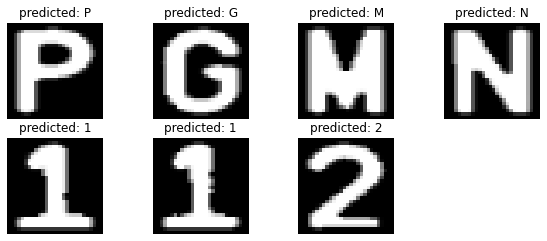

In [37]:
plt.figure(figsize=(10,6))
for i,ch in enumerate(char):
    img = cv2.resize(ch, (28,28))
    plt.subplot(3,4,i+1)
    plt.imshow(img,cmap='gray')
    plt.title(f'predicted: {show_results()[i]}')
    plt.axis('off')
plt.show()

In [40]:
from sklearn.metrics import classification_report, confusion_matrix

In [41]:
Y_pred = model.predict(validation_generator)

In [42]:
y_pred = np.argmax(Y_pred, axis=1)

In [43]:
print(confusion_matrix(validation_generator.classes, y_pred))

[[225   0   0 ...   0   0   0]
 [  0 252   0 ...   0   0   0]
 [  0   0 264 ...   0   0   0]
 ...
 [  0   6   0 ... 256   0   0]
 [  0   6   0 ...   1 243   2]
 [  0   1  21 ...   0   0 229]]


In [45]:
target_names = list(train_generator.class_indices.keys())

In [47]:
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           0       0.63      0.83      0.72       271
           1       0.90      0.94      0.92       268
           2       0.91      0.98      0.94       270
           3       0.95      1.00      0.97       259
           4       0.97      0.97      0.97       256
           5       0.95      0.99      0.97       271
           6       0.98      0.94      0.96       266
           7       0.97      0.97      0.97       259
           8       0.93      0.94      0.94       264
           9       0.97      0.97      0.97       264
           A       0.96      0.96      0.96       258
           B       0.98      0.88      0.93       267
           C       0.99      0.98      0.98       263
           D       0.96      0.81      0.88       267
           E       0.96      0.99      0.98       266
           F       0.98      0.96      0.97       257
           G       0.98      0.94      0.96       259
           H       0.91    

In [48]:
cf_matrix = confusion_matrix(validation_generator.classes, y_pred)

print(cf_matrix)

[[225   0   0 ...   0   0   0]
 [  0 252   0 ...   0   0   0]
 [  0   0 264 ...   0   0   0]
 ...
 [  0   6   0 ... 256   0   0]
 [  0   6   0 ...   1 243   2]
 [  0   1  21 ...   0   0 229]]


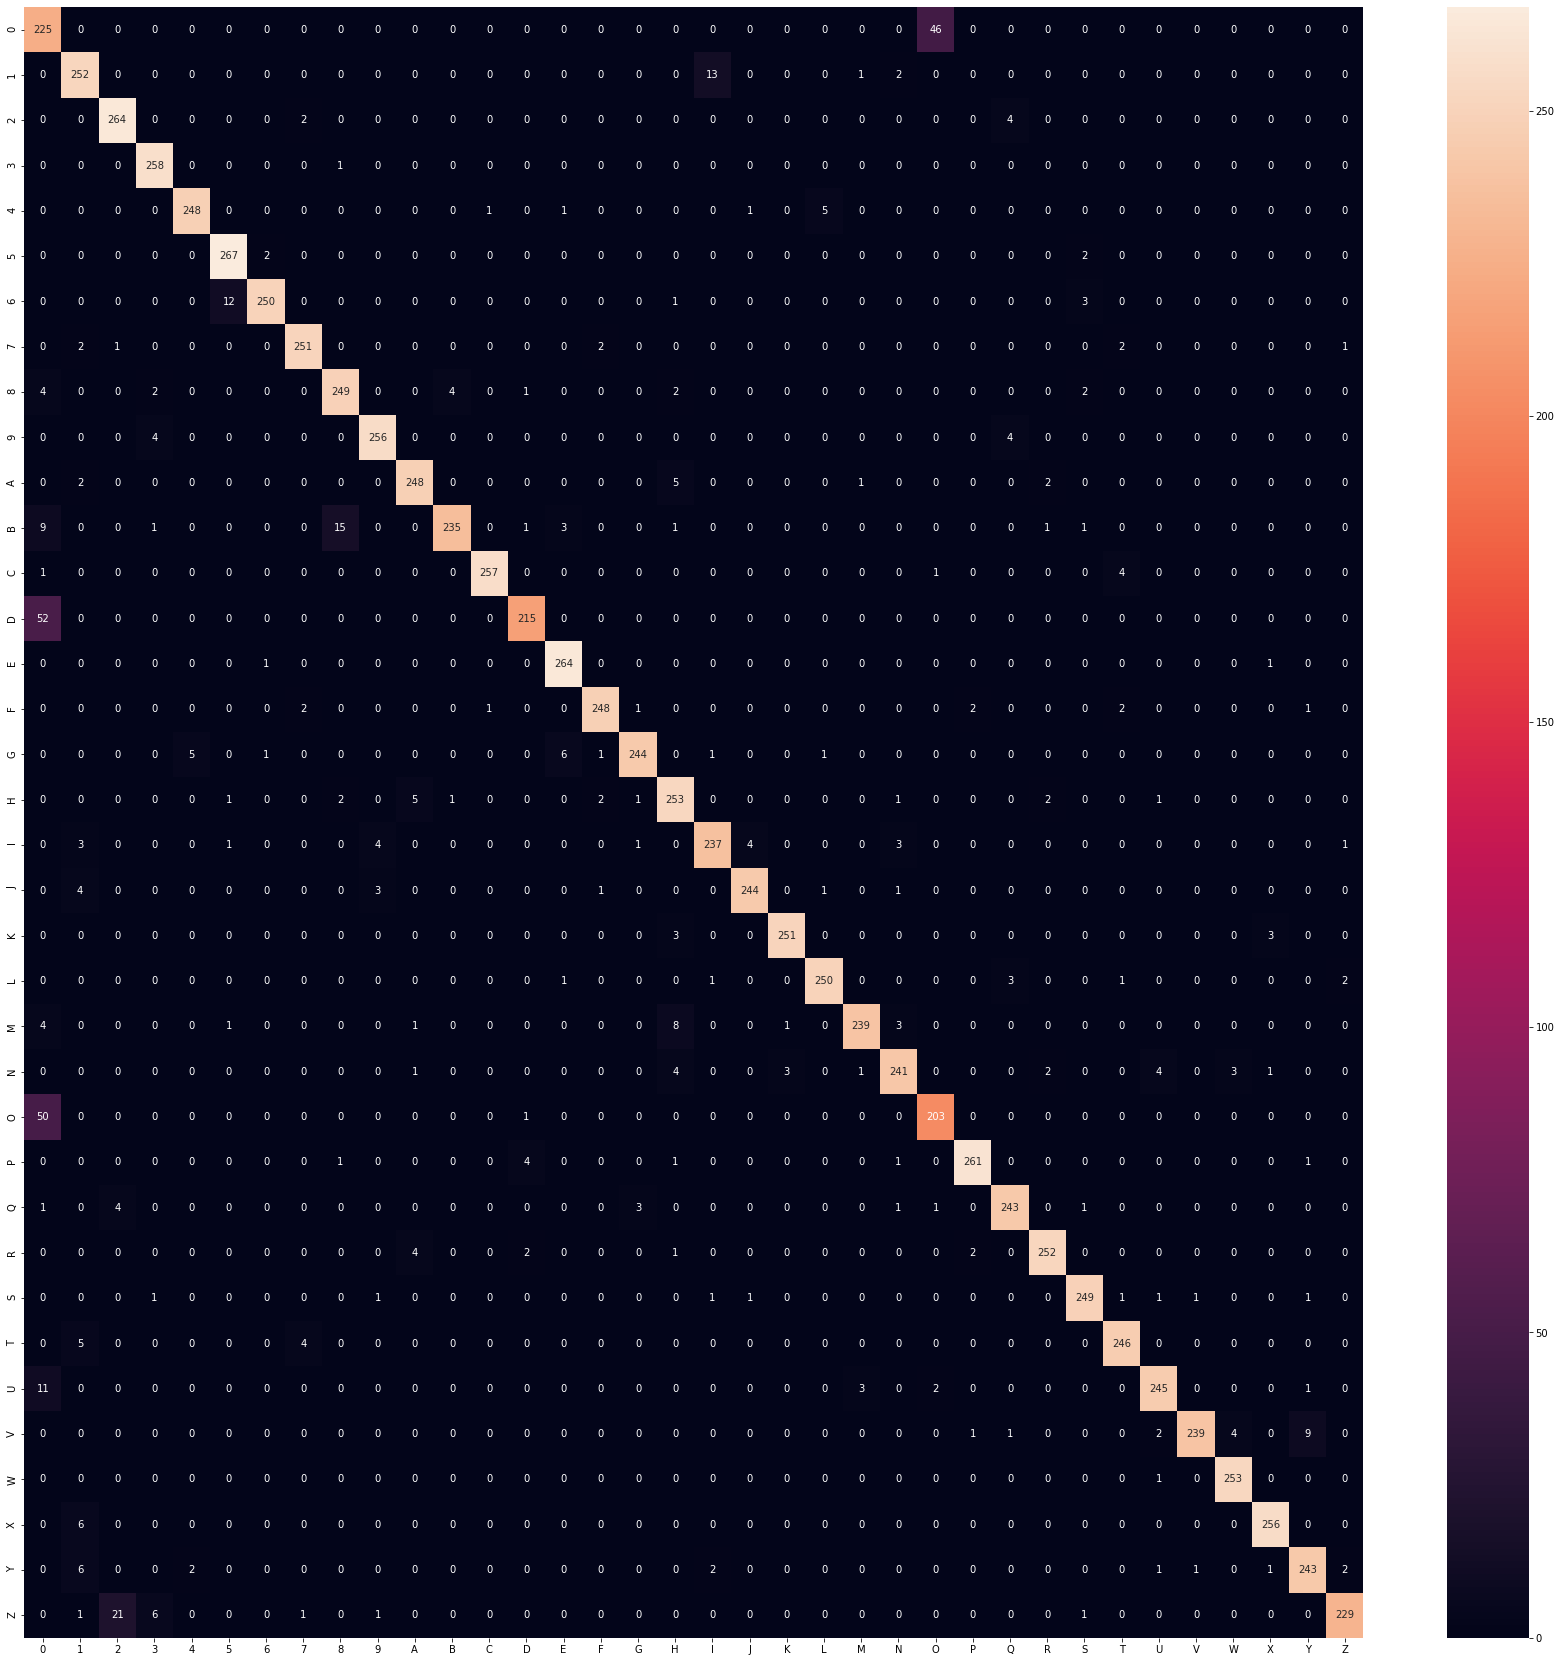

In [49]:
import seaborn as sns
import pylab as pl
plt.figure(figsize=(30, 30))
ax= plt.subplot()
picture = sns.heatmap(cf_matrix, annot=True, fmt='g', ax=ax);
ax.xaxis.set_ticklabels(target_names); ax.yaxis.set_ticklabels(target_names);

In [52]:
import visualkeras

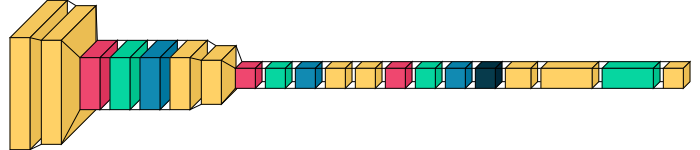

In [55]:
visualkeras.layered_view(model)

In [71]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
accuracy_score(validation_generator.classes,y_pred)

0.9434865900383141

In [78]:

f1_score(validation_generator.classes,y_pred, average='macro')

0.9446307841017804

In [76]:
recall_score(validation_generator.classes,y_pred, average='macro')

0.9436161767891781

In [77]:
precision_score(validation_generator.classes,y_pred, average='macro')

0.9474104188284797